# Next Best Action Model

This is a demo on a strategic next best action model using reinforcement leanring (fitted Q iteration).

Adapted for telco usecase by Sergei Gromov and Sergei Bazhin.

| Description | D002 (see [descriptions](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md)) |
|--|:--|
| Dataset | Generated internally, no external dependencies |
| Papers | Theocharous2015, Riedmiller2005 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md)) | 
| Installation | NA |
| Libs | Scikit-learn, Numpy |

## Формализация событий/действий/целевых цепочек
**События (events - states):**  
 - 0 - приближение к порогу отключения  
 - 1 - пересечение порога отключения  
 - 2 - зачисление платежа  
 - 3 - списание АП  
 - 4 - отключение пакета  
 - 5 - **подключение пакета (событие имеющее награду )**
 
**Действия (offers - actions):**  
 - 1 - реклама
 - 2 - маленька скидка
 - 3 - большая скидка
 
**Целевые цепочки (target sequence) :**
- приближение к порогу отключения -> **(a)реклама** -> зачисление платежа -> **(a)большая скидка** -> подключение пакета  
- пересечение порога отключения -> **(a)реклама** -> зачисление платежа -> **(a)маленькая скидка** -> подключение пакета  
- отключение пакета -> **(a) реклама** -> подключение пакета   

## Описание участка траектории
Есть 100 временных отрезков, которые разбиваются на 4 участка общей траектории: [0 -(1)- 25 -(2)- 50 -(3)- 75 -(4)- 99].  
Состояние формируется для участка траектории и награда так же считается для него.  
Действие предпринимается так же на границе двух траекторий - три границы - три действия в арсенале.  

``` 
 #  начальное состояние  
 [кластер абонента   
  время последнего события типа 0 - приближение к порогу отключения (100, если не было)
  время последнего события типа 1 - пересечение порога отключения
  время последнего события типа 2 - зачисление платежа
  время последнего события типа 3 - списание АП
  время последнего события типа 4 - отключение пакета
  время действия 1 (100, если не было)
  время действия 2
  время действия 3]
 #  действие-награда
  номер предложения/действия, которое мы даем на этом участке траектории (1,2,3)
  награда
 [новое состояние]
 признак финального участка траектории
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE

# Setting the parameters needed to export figures as PDFs 
# plt.rcParams.update({'font.size': 14, 'pdf.fonttype': 'truetype', 
#                     'font.family':'Candara', 'font.serif':['Candara']})

In [214]:
#
# Auxiliary functions
#

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

def multinomial_int(p):
    '''
    p array holds probs that all must sum to 1
    we draw one sample from 0..len(p) ints with probs of p
    '''
    return np.random.choice(list(range(len(p))), p=p)

def count(ndarray, val):
    return np.count_nonzero(ndarray == val)

def index(ndarray, val, default):
    try:
        return ndarray.tolist().index(val)
    except:
        return default

def find_offer_times(f):
    return np.nonzero(f)[0]

def offer_seq(f):
    # just return array with positive eleme
    return f[np.where(f > 0)]

def get_p_events(num_events, no_action_p=0.7):
    # сделаем массив вероятностей для событий с клиентом
    # num_events - число событий
    # no_action_p - вероятность события бездействия - самая большая

    p_events = np.array([no_action_p] +\
                        list((1-no_action_p)*softmax(np.random.randn(num_events-1)))) # добиваем в остальные события случайные вероятности, чтобы в сумме была 1

    # округлим верятности до 2 знаков и восстановим равенство единице суммы
    p_events = np.round(p_events, 2)
    delta = 1 - sum(p_events)
    p_events[0] += delta
    assert sum(p_events) == 1.0
    return p_events


def visualize_profiles(m):
    fig, ax = plt.subplots(figsize=(10, 20))
    chart = ax.imshow(m, cmap='viridis', interpolation='none')
    ax.set_aspect(0.5 * m.shape[1] / m.shape[0])
    ax.grid(False)
    ax.set_xlabel('Time')
    ax.set_ylabel('User ID')
    plt.colorbar(chart, fraction=0.025, pad=0.04, ax=ax)
    plt.show() 

In [333]:
#
# Environment parameters
#
# states
events = [
    0, # бездействие 
    1, # приближение к порогу отключения
    2, # пересечение порога отключения 
    3, # зачисление платежа
    4, # списание АП
    5, # отключение пакета  
    6  # подключение пакета (событие имеющее награду )
]

events_dict = {0 : 'бездействие', 
               1 : 'приближение к порогу отключения',
               2 : 'пересечение порога отключения', 
               3 : 'зачисление платежа',
               4 : 'списание АП',
               5 : 'отключение пакета',  
               6 : 'подключение пакета (событие имеющее награду )'}

# actions
offers = [
    1, # advertisement
    2, # small disocunt
    3  # large discount
]
offers_dict = dict([
    (1, 'advertisement'),
    (2, 'small disocunt'),
    (3, 'large discount')])

# кластер абонента
demogr = [
    0,  
    1,
    2,
    3
]

n = 1000 # users
k = 100  # time intervals
m = len(offers)    # offers
p_offers = [1 / m] * m # probs of offers - uniform

## Генерация профилей

####  Тестовая генерация
она не учитывает целевые цепочки и просто создает события согласно распределению p_events

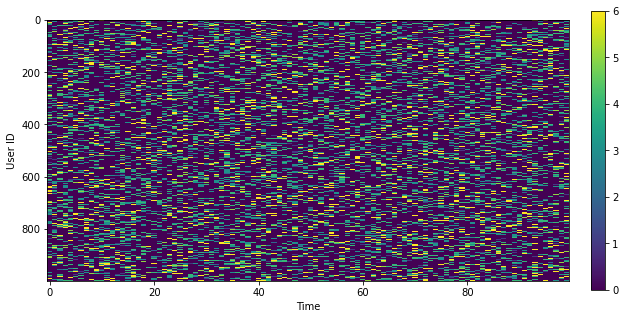

In [458]:
# иногда барахлит округление и надо перезапустить генерацию
while True:
    try :
        p_events = get_p_events(len(events), no_action_p=0.7)
        break
    except AssertionError:
        print("rounding error - will try one more time...")
P = np.random.choice(events, size=(n,k), p=p_events)
visualize_profiles(P)

## Генерация офферов/действий

In [289]:
# m, n, k 
# (3, 1000, 100)
# вокруг временых точек t_offers c разборосом в t_offer_jit генерируем с вероятностью p_offers 3 предложения 1, 2 или 3
# записываем результат в матрицу F - одной размерости с P

(3, 1000, 100)

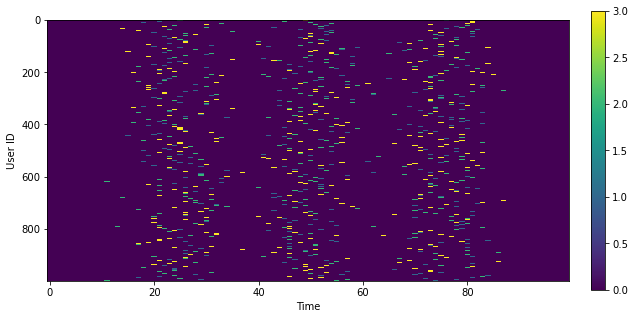

In [491]:
t_offers = np.linspace(0, k, m + 2).astype(int).tolist()[1 : -1]    # offer campaing times
t_offer_jit = 5                                           # offer time jitter, standard deviation in time units
offers_jitter = np.rint(t_offer_jit * np.random.randn(n, len(t_offers))) # deviation from offer times
offer_times = (offers_jitter + np.repeat([t_offers], n, axis=0)).astype(int) # time labels at which we make offers
offers_sampled = np.random.choice(offers, size=offer_times.shape, p=p_offers) # offers that we make at offer times
F = np.zeros_like(P)
x_indices = np.array([[i]*offer_times.shape[-1] for i in range(n)]).flatten() # these are just [0,0,0], [1,1,1] ... [999,999,999] flattened
F[x_indices, offer_times.flatten()] = offers_sampled.flatten()
visualize_profiles(F)

In [278]:
events_dict, offers_dict

({0: 'бездействие',
  1: 'приближение к порогу отключения',
  2: 'пересечение порога отключения',
  3: 'зачисление платежа',
  4: 'списание АП',
  5: 'отключение пакета',
  6: 'подключение пакета (событие имеющее награду )'},
 {1: 'advertisement', 2: 'small disocunt', 3: 'large discount'})

```
1->(1)->3->(3)-> +
2->(1)->3->(1)-> +
5->(1)->(1) + 
0 : приближение к порогу отключения -> (a)реклама -> зачисление платежа -> (a)большая скидка -> подключение пакета
[0.7 , 0.2, 0.02, 0.02, 0.02, 0.02, 0.02] -> [0.7 , 0.02, 0.02, 0.2, 0.02, 0.02, 0.02] -> [0.7 , 0.02, 0.02, 0.02, 0.02, 0.02, 0.2]

1 : пересечение порога отключения -> (a)реклама -> зачисление платежа -> (a)маленькая скидка -> подключение пакета
[0.7 , 0.02, 0.2, 0.02, 0.02, 0.02, 0.02] (a)реклама -> [0.7 , 0.02, 0.02, 0.2, 0.02, 0.02, 0.02] -> (a)маленькая скидка -> [0.7 , 0.02, 0.02, 0.02, 0.02, 0.02, 0.2] 

2 : отключение пакета -> (a) реклама ->*any event seq*-> (a)реклама -> подключение пакета
[0.7 , 0.02, 0.02, 0.02, 0.02, 0.2, 0.02] -> [0.7 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.05] -> [0.7 , 0.02, 0.02, 0.02, 0.02, 0.02, 0.2]

```

## Генерация событий 

In [586]:
target_events={0:0, 1:0, 2:0} # counter of target chains
current_pattern = -1 # target reward pattern id from the memo above

pos_1 = 0 # 1st occurence of target action in seq of F offers/actions
pos_2 = 0 # 2nd occurence of target action in seq of F offers/actions

# loop through offers and identify if it fits the pattern
with tqdm(total=n) as pbar:
    for i, (t, offer_ids) in enumerate(zip(offer_times, offers_sampled)):
        # pattern 0: 1 -> 3
        if (offer_ids[0]==1 and offer_ids[1]==3): #1->2
            target_events[0] += 1
            current_pattern = 0
            pos_1, pos_2 = 0,1
        elif  (offer_ids[0]==1 and offer_ids[2]==3): #1->3
            target_events[0] += 1
            current_pattern = 0
            pos_1, pos_2 = 0,2
        elif offer_ids[1]==1 and offer_ids[2]==3: #2->3
            target_events[0] += 1
            current_pattern = 0
            pos_1, pos_2 = 1,2
        # pattern 1: 1 -> 2
        elif (offer_ids[0]==1 and offer_ids[1]==2): #1->2
            target_events[1] += 1
            current_pattern = 1
            pos_1, pos_2 = 0,1
        elif (offer_ids[0]==1 and offer_ids[2]==2): #1->3
            target_events[1] += 1
            current_pattern = 1
            pos_1, pos_2 = 0,2
        elif (offer_ids[1]==1 and offer_ids[2]==2): #2->3
            target_events[1] += 1
            current_pattern = 1
            pos_1, pos_2 = 1,2
        # pattern 2: 1 -> 1
        elif (offer_ids[0]==1 and offer_ids[1]==1): # 1->2
            target_events[2] += 1
            current_pattern = 2
            pos_1, pos_2 = 0,1
        elif (offer_ids[1]==1 and offer_ids[2]==1): # 2->3
            target_events[2] += 1
            current_pattern = 2
            pos_1, pos_2 = 1,2
        else:
            current_pattern = -1
            pos_1, pos_2 = 0, 0

        if current_pattern == 0:
            p_events = ([0.7 , 0.2 , 0.02, 0.02, 0.02, 0.02, 0.02], # 1 - приближение к порогу отключения 
                        [0.7 , 0.02, 0.02, 0.2 , 0.02, 0.02, 0.02], # 3 - зачисление платежа 
                        [0.7 , 0.02, 0.02, 0.02, 0.02, 0.02, 0.2])  # 6 - подключение пакета
        elif current_pattern == 1:
            p_events = ([0.7 , 0.02, 0.2 , 0.02, 0.02, 0.02, 0.02], # 2 - пересечение порога отключения
                        [0.7 , 0.02, 0.02, 0.2 , 0.02, 0.02, 0.02], # 3 - зачисление платежа
                        [0.7 , 0.02, 0.02, 0.02, 0.02, 0.02, 0.2] ) # 6 - подключение пакета
        elif current_pattern == 2:
            p_events = ([0.7 , 0.02, 0.02, 0.02, 0.02, 0.2,  0.02], # 5 - отключение пакета
                        [0.7 , 0.06, 0.06, 0.06, 0.06, 0.06, 0.00], # все равновероятно, кроме подключения пакера
                        [0.7 , 0.02, 0.02, 0.02, 0.02, 0.02, 0.2]) # 6 - подключение пакета
        else:
            p_events = ([0.7 , 0.058, 0.058, 0.058, 0.058, 0.058,  0.01], # 
                        [0.7 , 0.058, 0.058, 0.058, 0.058, 0.058,  0.01], # все равновероятно, кроме подключения пакета
                        [0.7 , 0.058, 0.058, 0.058, 0.058, 0.058,  0.01]) # 
            
        # add some noise
        if (current_pattern >= 0) and (np.random.randint(0,100) > 90): 
            p_events = ([0.7 , 0.058, 0.058, 0.058, 0.058, 0.058,  0.01], # 
            [0.7 , 0.058, 0.058, 0.058, 0.058, 0.058,  0.01], # все равновероятно, кроме подключения пакета
            [0.7 , 0.058, 0.058, 0.058, 0.058, 0.058,  0.01]) # 
            
        P[i, 0        : t[pos_1]] = np.random.choice(events, t[pos_1], p=p_events[0])
        P[i, t[pos_1] : t[pos_2]] = np.random.choice(events, t[pos_2] - t[pos_1], p=p_events[1])
        P[i, t[pos_2] :         ] = np.random.choice(events, k - t[pos_2], p=p_events[2])
        
        # if (np.random.randint(0, 100) > 90) and (pos_1 >0):
        #     break
            
        pbar.update(1)
        
print(f"Всего целевых цепочек - {sum(target_events.values())}" )

  0%|          | 0/1000 [00:00<?, ?it/s]

Всего целевых цепочек - 549


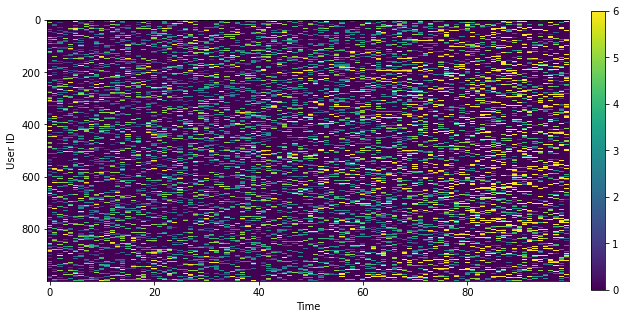

In [587]:
visualize_profiles(P)

In [588]:
D = np.random.choice(demogr, size=n)

In [47]:
from collections import Counter
Counter(P.flatten()) # number of events

Counter({0.0: 86268, 1.0: 8085, 2.0: 5647})

### Debug zone

In [3]:
p_offers = [1 / m] * m                                    # offer probabilities (behavioral policy)
t_offers = np.linspace(0, k, m + 2).tolist()[1 : -1]      # offer campaing times = [25.0, 50.0, 75.0]
t_offer_jit = 5                                           # offer time jitter, standard deviation in time units 

In [17]:
# P = np.zeros((n, k)) # matrix of profile events
# F = np.zeros((n, k)) # offer history
# D = np.zeros((n, 1)) # demographic features

In [19]:
u=0
D[u, 0] = np.random.binomial(1, 0.5)

# determine m time points to issue offers for customer u
offer_times_u = np.rint(t_offer_jit * np.random.randn(len(t_offers)) + t_offers)

In [25]:
p_offers

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

In [53]:
np.random.multinomial(2, p_offers)

array([0, 2, 0])

In [67]:
multinomial_int(p_offers) + 1 

1

In [64]:
[1 / m] * m 

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

In [31]:
F.max()

3.0

In [4]:
P.shape

(1000, 100)

In [6]:
F[45]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
P[45]

array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 1.,
       0., 1., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 2., 0.])

### Code condinue - cut the data into trajectories

![trajectories](i09-transition-cutting.png)

In [8]:
#
# Cut trajectories into transitions
#
def state_features(p, f, d, t_start, t_end):
    p_frame = p[0:t_end]
    f_frame = f[0:t_end]
    f1 = index(f_frame, 1, k)  
    f2 = index(f_frame, 2, k)
    f3 = index(f_frame, 3, k)
    return np.array([
        d[0],                  # demographic features
        count(p_frame, 1),     # number of visits
        f1,                    # first time offer 1 was issued
        f2,                    # first time offer 2 was issued
        f3                     # first time offer 3 was issued
    ])

def frame_reward(p, t_start, t_end):
    return count(p[t_start:t_end], 2)   # number of purchases in the time frame

def offer_time_ranges(times):
    rng = [-1] + times + [k]
    return list(zip(map(lambda x: x + 1, rng), rng[1:]))
    
def prepare_trajectories(P, F, D):
    T = []
    for u in range(0, n):
        offer_times = find_offer_times(F[u]).tolist()
        ranges = offer_time_ranges(offer_times)
        
        T_u = []
        for r in range(0, len(ranges)):
            (t_start, t_end) = ranges[r]
            state = state_features(P[u], F[u], D[u], 0, t_start)
            reward = frame_reward(P[u], t_start, t_end)
            state_new = state_features(P[u], F[u], D[u], t_start, min(t_end + 1, k))
            is_end_of_trajectory = t_end >= k
            
            if(t_end in offer_times): 
                action = F[u, t_end]
            else:
                action = 1 # default action
                
            T_u.append([state, action, reward, state_new, is_end_of_trajectory])
            
        T.append(T_u) 
        
    return np.array(T)

T = prepare_trajectories(P, F, D)
Tt = prepare_trajectories(Pt, Ft, Dt)

/tmp/ipykernel_1255/3762033957.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(T)


In [10]:
# demographic features
# number of visits
# first time offer 1 was issued
# first time offer 2 was issued
# first time offer 3 was issued

T[0][0] # первая часть траектории по нулевому пользователю; общая структура элемента траектории : state, action, reward, state_new, is_end_of_trajectory

array([array([  0.,   0., 100., 100., 100.]), 3.0, 0,
       array([  0.,   2., 100., 100.,  21.]), False], dtype=object)

In [61]:
len(T[0])

4

In [17]:
P[0][:25]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0.])

In [18]:
T[0]

array([[array([  0.,   0., 100., 100., 100.]), 3.0, 0,
        array([  0.,   2., 100., 100.,  21.]), False],
       [array([  0.,   2., 100., 100.,  21.]), 3.0, 1,
        array([  0.,   4., 100., 100.,  21.]), False],
       [array([  0.,   4., 100., 100.,  21.]), 3.0, 2,
        array([  0.,   5., 100., 100.,  21.]), False],
       [array([  0.,   5., 100., 100.,  21.]), 1, 0,
        array([  0.,   7., 100., 100.,  21.]), True]], dtype=object)

## Policy Learning

### Debug zone

In [71]:
n,m

(1000, 3)

In [70]:
T.shape

(1000, 1, 5)

In [80]:
T[0][0][0]

array([  0.,   0., 100., 100., 100.])

In [84]:
state, action, reward, state_new, is_end_of_trajectory

(array([  0.,   0., 100., 100., 100.]),
 1,
 0,
 array([  0.,   0., 100., 100., 100.]),
 True)

In [87]:
len(X), len(Y)

(1000, 1000)

### Code continue

In [9]:
len(T)

1000

In [14]:
n

1000

In [25]:
type(T[0])

list

In [23]:
for i in range(0,4):
    for item in T:
        sample=item[i]

In [24]:
sample

array([array([  0.,   5., 100.,  23., 100.]), 1, 1,
       array([  0.,   7., 100.,  23., 100.]), True], dtype=object)

In [25]:
T[-1][-1]

array([array([  0.,   5., 100.,  23., 100.]), 1, 1,
       array([  0.,   7., 100.,  23., 100.]), True], dtype=object)

In [33]:
from tqdm.notebook import tqdm
#
# Find the optimal action under a greedy policy and corresponding state value
#
def best_action(Q, state, actions):
    v_best = 0
    a_best = 0
    for a in actions:
        v = Q([np.append(state, a)])[0]
        if(v > v_best):
            v_best = v
            a_best = a
            
    return a_best, v_best

def Q_0(sa):
    return [1]

Q = Q_0
score = []
for i in range(1, 5): # FQI iterations
    X = []
    Y = []
    for i in tqdm(range(0,4)):
        for item in T:
            sample=item[i]
            state, action, reward, state_new, is_end_of_trajectory = sample
            x = np.append(state, action) # feature vector consists of state-action pairs

            a_best, v_best = best_action(Q, state_new, offers)

            y = reward + v_best    # we ignore the initial conditions (ends of trajectories) for the sake of illustration      

            X.append(x)
            Y.append(y)
    
    regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=10, oob_score=True)
    regr.fit(X, Y)   
    score.append(regr.oob_score_)
    Q = regr.predict

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [34]:
len(score)

4

In [35]:
score

[0.4352593380195454, 0.7517597022480891, 0.820727845193426, 0.8584319142079472]

In [59]:
X[123]

array([  0.,   0., 100., 100., 100.,   2.])

In [27]:
# demographic features
# number of visits
# first time offer 1 was issued
# first time offer 2 was issued
# first time offer 3 was issued

# Values of possible actions for a user who did not get any offer yet  
print(Q([[0, 0, 100, 100, 100, 1]]))
print(Q([[0, 0, 100, 100, 100, 2]]))
print(Q([[0, 0, 100, 100, 100, 3]]))

# Values of possible actions for a user who got offer #1 at time step 20  
print(Q([[0, 0, 20, 100, 100, 1]]))
print(Q([[0, 0, 20, 100, 100, 2]]))
print(Q([[0, 0, 20, 100, 100, 3]]))

[13.55230739]
[6.26474602]
[5.96279435]
[13.52702846]
[13.52702846]
[17.90256729]


In [164]:
# Values of possible actions for a user who did not get any offer yet  
print(Q([[0, 0, 100, 100, 100, 1]]))
print(Q([[0, 0, 100, 100, 100, 2]]))
print(Q([[0, 0, 100, 100, 100, 3]]))

# Values of possible actions for a user who got offer #1 at time step 20  
print(Q([[0, 0, 20, 100, 100, 1]]))
print(Q([[0, 0, 20, 100, 100, 2]]))
print(Q([[0, 0, 20, 100, 100, 3]]))

[13.61321886]
[5.82460587]
[5.82460587]
[13.93350275]
[13.93350275]
[18.20843831]


In [165]:
#
# Use the test set to evaluate the policy
#
states = Tt[:, :, 0].flatten().tolist()

values = []
best_actions = []
for s in states:
    a_best, v_best = best_action(Q, s, offers)
    values.append(v_best)
    best_actions.append(a_best)
    
s_tsne = TSNE(learning_rate = 100).fit_transform(states)

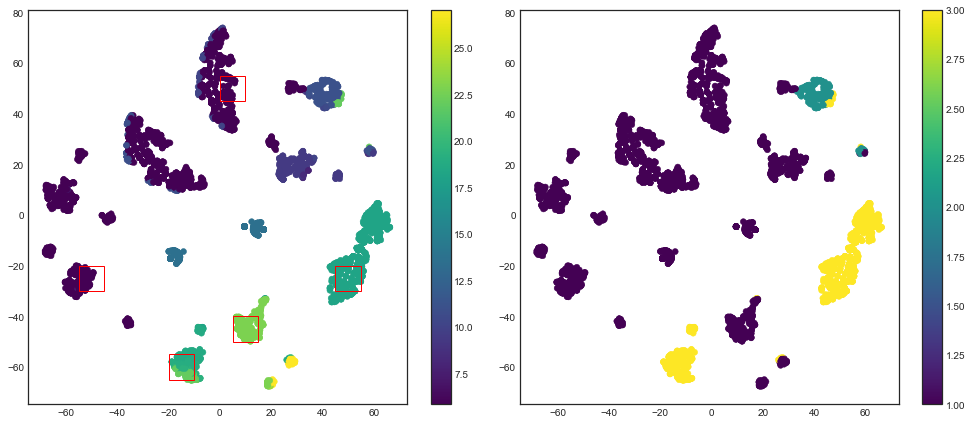

Segment ((-55, -45), (-30, -20)):
 [[100.  29.  48.]
 [100.  29.  48.]
 [100.  26.  51.]
 [100.  26.  51.]
 [100.  38.  52.]]
Segment ((45, 55), (-30, -20)):
 [[ 20. 100. 100.]
 [ 20. 100. 100.]
 [ 20. 100. 100.]
 [ 21. 100. 100.]
 [ 20. 100. 100.]]
Segment ((-20, -10), (-65, -55)):
 [[ 31.  54. 100.]
 [ 31.  54. 100.]
 [ 28.  52. 100.]
 [ 20.  43. 100.]
 [ 20.  43. 100.]]
Segment ((0, 10), (45, 55)):
 [[100. 100.  25.]
 [100. 100.  25.]
 [100. 100.  25.]
 [100. 100.  26.]
 [100. 100.  26.]]
Segment ((5, 15), (-50, -40)):
 [[ 27. 100.  54.]
 [ 27. 100.  54.]
 [ 21. 100.  42.]
 [ 21. 100.  42.]
 [ 14. 100.  49.]]


In [172]:
#
# Visualuze the Q-values and best action for individual users
#

#
# Segment boxes need to be set manually because the tSNE
# projection changes unpredictabley as the data changes  
#
segments = [
    ( (-55, -45), (-30, -20) ),
    ( (45, 55),   (-30, -20) ),
    ( (-20, -10), (-65, -55) ),
    ( (0, 10),    (45, 55) ),
    ( (5, 15),    (-50, -40) )
]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
scatter = ax[0].scatter(s_tsne[:, 0], s_tsne[:, 1], c=values, cmap='viridis')
plt.colorbar(mappable=scatter, ax=ax[0])
for s in segments:
    rect = Rectangle((s[0][0], s[1][0]), s[0][1] - s[0][0], s[1][1] - s[1][0], linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)


scatter = ax[1].scatter(s_tsne[:, 0], s_tsne[:, 1], c=best_actions, cmap='viridis')
plt.colorbar(mappable=scatter, ax=ax[1])
plt.tight_layout()
plt.show()


for s in segments:
    segment = ((s_tsne[:, 0] > s[0][0]) & (s_tsne[:, 0] < s[0][1]) & (s_tsne[:, 1] > s[1][0]) & (s_tsne[:, 1] < s[1][1]))
    print(f'Segment {s}:\n', np.array(states)[segment, 2:][:5])

# Policy Evaluation

FQI provides a way to learn the Q function and derive some policy (e.g. epsilon-greedy) from it. 
If we change the policy, we need to evaluate its performance. It can be done using historical trajectories.

In [173]:
def make_epsilon_greedy_policy(Q, eps):
    def egreedy_policy(state, action):
        a_best, v_best = best_action(Q, state, offers)

        if(a_best == action):
            return 1 - eps
        else:
            return eps / (m - 1)
        
    return egreedy_policy


# Probability of action given state
def behavioral_policy(state, action):
    return 1 / m

# Estimates the target policy return based on 
# the profiles (trajectories) P generated under the behavioral policy 
def evaluate_policy_return(T, behavioral_policy, target_policy):
    returns = []
    for trajectory in T:                                                   
        importance_weight = 1
        trajectory_reward = 0
        for transition in trajectory:            
            state, action, reward  = transition[0:3]
            action_prob_b = behavioral_policy(state, action)
            action_prob_t = target_policy(state, action)
            
            importance_weight *= (action_prob_t / action_prob_b) 
            trajectory_reward += reward
            
        returns.append(trajectory_reward * importance_weight)
        
    return np.mean(returns)   

In [174]:
policy_returns = []
eps = np.linspace(0, 2/3, num = 10)
for e in eps:
    policy = make_epsilon_greedy_policy(Q, e)
    policy_returns.append( evaluate_policy_return(T, behavioral_policy, policy) )

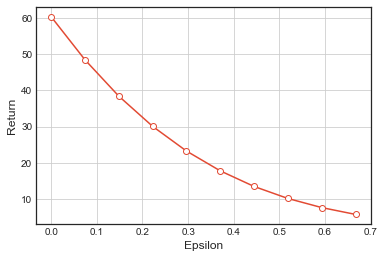

In [137]:
plt.style.use('seaborn-white')
plt.grid(True)
plt.xlabel('Epsilon')
plt.ylabel('Return')
plt.plot(eps, policy_returns, '-o', mfc='w')
plt.show()